In [1]:
import os

import pandas as pd
import numpy as np
import collections

import json

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from dateutil import parser

from sklearn import preprocessing
from tqdm import tqdm

from joblib import Parallel, delayed

import collections

import pickle

from sklearn import metrics

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./dataframe.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-37,road_conditions-19,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1
0,2,42,8706,10,2017-09-04 22:15:00,0,0,1,0,2,...,0,0,1,0,0,0,0,0,0,1
1,4,42,16864,16,2020-09-24 09:30:00,0,0,2,0,3,...,0,0,0,0,0,0,1,0,0,1
2,4,42,8706,9,2021-04-20 18:55:00,0,0,1,0,2,...,0,0,1,0,0,1,1,0,0,1
3,4,42,15435,9,2021-04-28 12:20:00,0,0,1,0,2,...,0,0,1,0,0,1,0,0,0,1
4,0,42,15427,9,2021-04-27 21:00:00,2,0,1,0,2,...,0,0,0,0,0,1,0,0,0,1


# Task 1: Create new feature (index_)

> index_ = h_address * most_common_severity_region / h_region

In [4]:
df['index_'] = np.nan

In [5]:
print('unique: ', df['address'].nunique(), '/', df.shape[0])

unique:  17907 / 417518


In [6]:
# index_ = h_address * most_common_severity_region / h_region

h_region = {} 
h_address = {}
most_common_severity_region = {}

In [7]:
def get_index(row):
    return h_address[int(row['address'])] * most_common_severity_region[int(row['region'])] / h_region[int(row['region'])]

In [8]:
for region in tqdm(df['region'].unique()):
    h_region[region] = len(df[df['region'] == region].region.values) / df.shape[0]

100%|██████████| 914/914 [00:00<00:00, 1114.22it/s]


In [9]:
for address in tqdm(df['address'].unique()):
    h_address[address] = len(df[df['address'] == address].address.values) / len(df[df['region'] == df[df['address'] == address].region.values[0]].region.values)

100%|██████████| 17907/17907 [00:48<00:00, 369.74it/s]


In [10]:
for region in tqdm(df['region'].unique()):
    most_common_severity_region[region] = collections.Counter(df[df['region'] == region].severity.values).most_common(1)[0][1]

100%|██████████| 914/914 [00:00<00:00, 1088.62it/s]


In [11]:
index_data = []

for i in tqdm(range(df.shape[0])):
    index_data.append(get_index(df.iloc[i]))

100%|██████████| 417518/417518 [00:55<00:00, 7507.60it/s]


Добавил новую фичу назвал ее index_ и заполнил его индексом который вычислил для каждого ДТП

In [12]:
df['index_'] = index_data

In [13]:
df.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-19,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1,index_
0,2,42,8706,10,2017-09-04 22:15:00,0,0,1,0,2,...,0,1,0,0,0,0,0,0,1,19072.718118
1,4,42,16864,16,2020-09-24 09:30:00,0,0,2,0,3,...,0,0,0,0,0,1,0,0,1,11808.694616
2,4,42,8706,9,2021-04-20 18:55:00,0,0,1,0,2,...,0,1,0,0,1,1,0,0,1,19072.718118
3,4,42,15435,9,2021-04-28 12:20:00,0,0,1,0,2,...,0,1,0,0,1,0,0,0,1,8791.331008
4,0,42,15427,9,2021-04-27 21:00:00,2,0,1,0,2,...,0,0,0,0,1,0,0,0,1,8828.582410


# Task 2: Clustering

In [14]:
X = df.drop(['datetime'], axis=1)
X_std = preprocessing.StandardScaler().fit_transform(X)

In [15]:
sizes = range(2, 6)
figsize = (28, 15)

Для выбора модели я буду использовать две метрики:
1. Индекс Калинского-Харабаза (синие графики) - чем выше показатель тем лучше
2. Индекс Дэвиса болдина (оранжевые графики) - в идеале должен стремиться к нулю (0 = идельно)

100%|██████████| 4/4 [01:36<00:00, 24.17s/it]

drow charts...


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

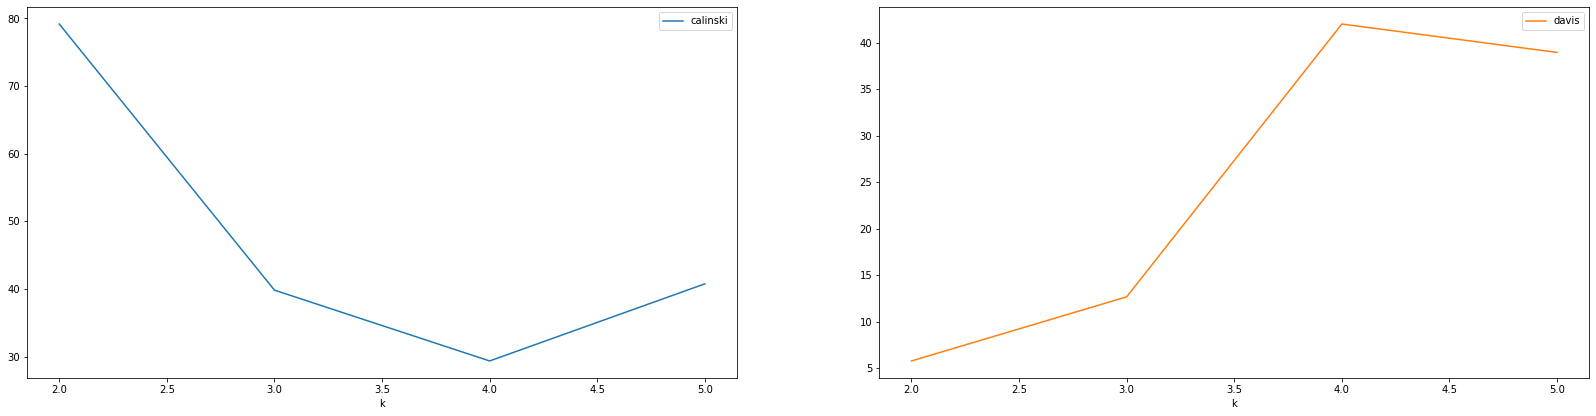

In [16]:
# sils = []
chs = []
dbs = []

for k in tqdm(sizes):
    model = GaussianMixture(n_components=k, random_state=0)
   
    model.fit(X_std)
    
    predict = model.predict(X_std)

    chs.append(
        metrics.calinski_harabasz_score(X, predict)
    )
    dbs.append(
        metrics.davies_bouldin_score(X, predict)
    )

print('drow charts...')
fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame(
    {
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    }
).set_index('k').plot(ax=ax, subplots=True, layout=(2, 2))

100%|██████████| 4/4 [00:45<00:00, 11.41s/it]


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

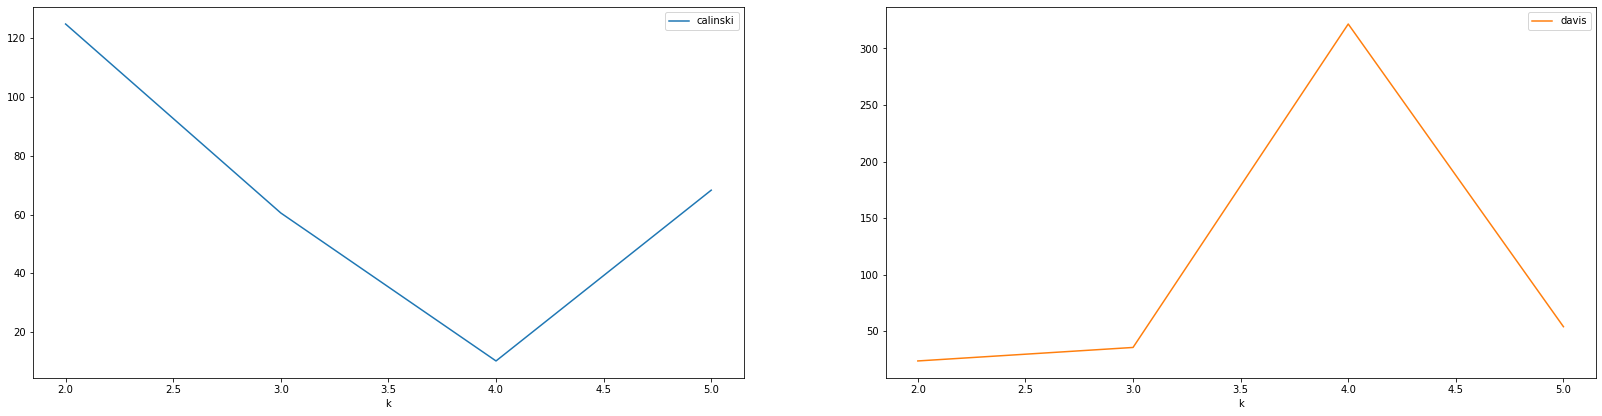

In [17]:
# sils = []
chs = []
dbs = []

for k in tqdm(sizes):
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(X_std)
    
    predict = model.labels_

    chs.append(
        metrics.calinski_harabasz_score(X, predict)
    )
    dbs.append(
        metrics.davies_bouldin_score(X, predict)
    )

fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame(
    {
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    }
).set_index('k').plot(ax=ax, subplots=True, layout=(2, 2))

100%|██████████| 4/4 [00:08<00:00,  2.22s/it]


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

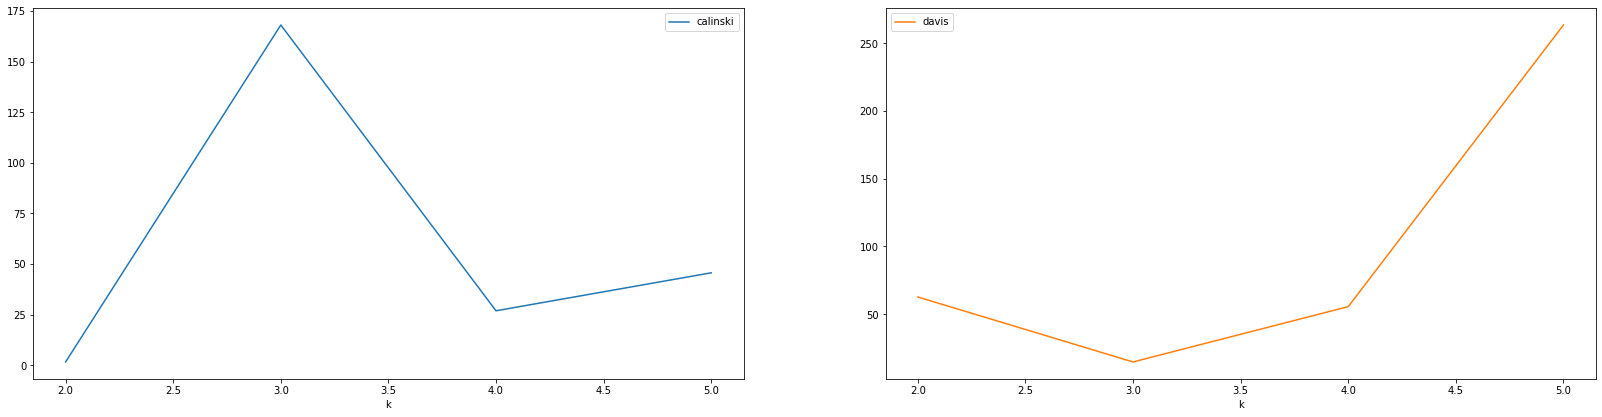

In [18]:
chs = []
dbs = []

for k in tqdm(sizes):
    model = MiniBatchKMeans(n_clusters=k, random_state=0)
    model.fit(X_std)
    
    predict = model.labels_

    chs.append(
        metrics.calinski_harabasz_score(X, predict)
    )
    dbs.append(
        metrics.davies_bouldin_score(X, predict)
    )

fig, ax = plt.subplots(figsize=figsize)
pd.DataFrame(
    {
        "calinski": chs,
        "davis": dbs,
        "k": sizes,
    }
).set_index('k').plot(ax=ax, subplots=True, layout=(2, 2))

Исходя из этих двух метрик которые я проверил на одинаковом наборе данных для всех моделей (KMeans, GaussianMixture, MiniBatchKMeans) показатели для разного кол-ва кластеров.
В виду того что необходимо четкое кол-во кластеро (три) то по всем показателям метрик лучше всего себя показывает модель кластеризации MiniBatchKMeans

Я выбираю модель MiniBatchKMeans для распределения ДТП по кластерам

In [19]:
X = df.drop(['datetime'], axis=1)
X_std = preprocessing.StandardScaler().fit_transform(X)

model = MiniBatchKMeans(n_clusters=3, random_state=0)
model.fit(X_std)

MiniBatchKMeans(n_clusters=3, random_state=0)

In [20]:
clusters = model.fit_predict(X_std)
clusters

array([2, 0, 1, ..., 0, 0, 0])

In [21]:
df['cluster'] = clusters

Даем названия кластерам исходя из распределения данных

<AxesSubplot:>

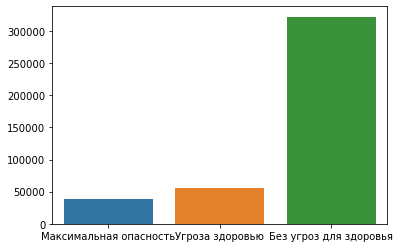

In [22]:
clusters_viz = dict(collections.Counter(clusters))
viz = {}
viz['Максимальная опасность'] = clusters_viz[2]
viz['Угроза здоровью'] = clusters_viz[1]
viz['Без угроз для здоровья'] = clusters_viz[0]

def rename_col(x):
    name = x
    if x == 0:
        name = 'Без угроз для здоровья'
    elif x == 1:
        name = 'Угроза здоровью'
    elif x == 2:
        name = 'Максимальная опасность'
    
    return name

df['cluster'] = df['cluster'].apply(lambda x: rename_col(x))

sns.barplot(data=pd.DataFrame([viz]))

In [23]:
df.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1,index_,cluster
0,2,42,8706,10,2017-09-04 22:15:00,0,0,1,0,2,...,1,0,0,0,0,0,0,1,19072.718118,Максимальная опасность
1,4,42,16864,16,2020-09-24 09:30:00,0,0,2,0,3,...,0,0,0,0,1,0,0,1,11808.694616,Без угроз для здоровья
2,4,42,8706,9,2021-04-20 18:55:00,0,0,1,0,2,...,1,0,0,1,1,0,0,1,19072.718118,Угроза здоровью
3,4,42,15435,9,2021-04-28 12:20:00,0,0,1,0,2,...,1,0,0,1,0,0,0,1,8791.331008,Без угроз для здоровья
4,0,42,15427,9,2021-04-27 21:00:00,2,0,1,0,2,...,0,0,0,1,0,0,0,1,8828.582410,Без угроз для здоровья


# Task 3: Train & Test split dataset

Перемешать датасет чтобы было разнообразнее

In [24]:
df = df.sample(frac=1).reset_index(drop=True)

Разделить на целевую переменную и данные

In [25]:
X = df.drop('cluster', axis=1)
y = df['cluster']

Разбить датасет на тестовую и обучающую выборки

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [33]:
X_train['cluster'] = y_train
df_train = X_train

In [34]:
X_test['cluster'] = y_test
df_test = X_test

Результат осталось сохранить

In [35]:
df_train.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1,index_,cluster
33966,0,749,12385,10,2016-09-28 04:00:00,0,0,1,12,2,...,1,0,0,0,0,0,0,1,1.499656e+04,Без угроз для здоровья
293924,2,532,8051,12,2017-04-17 22:00:00,0,0,1,29,2,...,0,0,0,0,0,1,0,1,4.784584e+03,Без угроз для здоровья
201937,0,92,1393,15,2019-10-28 23:50:00,2,0,1,9,3,...,0,0,0,0,0,0,0,1,3.194049e+06,Без угроз для здоровья
169377,2,297,16735,11,2019-12-14 07:40:00,2,0,1,12,3,...,1,0,0,1,0,0,0,1,3.930857e+03,Без угроз для здоровья
370605,4,123,7329,16,2018-09-13 19:15:00,0,0,1,7,2,...,1,0,0,0,0,0,0,1,1.111433e+05,Без угроз для здоровья


In [36]:
df_test.head()

,light,region,address,category,datetime,severity,dead_count,injured_count,parent_region,participants_count,...,road_conditions-40,road_conditions-27,participant_categories-0,participant_categories-5,participant_categories-2,participant_categories-3,participant_categories-4,participant_categories-1,index_,cluster
22628,4,413,1677,16,2020-09-12 11:20:00,2,0,1,25,3,...,1,0,0,0,0,0,0,1,5.678462e+05,Без угроз для здоровья
168734,4,268,14729,16,2017-05-16 16:16:00,0,0,1,16,2,...,1,0,0,0,0,0,0,1,9.369585e+03,Без угроз для здоровья
67828,0,880,4891,9,2016-10-07 23:45:00,2,0,1,29,2,...,0,0,0,1,0,0,0,1,2.750318e+04,Без угроз для здоровья
363613,4,134,11919,16,2015-05-21 16:40:00,2,0,1,9,2,...,1,0,0,0,0,1,0,1,5.256647e+04,Без угроз для здоровья
70372,4,142,2009,12,2015-07-18 17:10:00,2,0,1,25,2,...,1,0,0,0,0,1,0,1,4.944898e+06,Без угроз для здоровья


# Task 4: Export datasets

In [38]:
df.to_csv("dataset.csv")
df_train.to_csv("train_df.csv")
df_test.to_csv("test_df.csv")